In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import statsmodels.stats.api as sms
import scipy.stats as st

C:\Users\jenli\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Read csv
data= pd.read_csv("AB Test Case Study/sample_data.csv")

In [3]:
#Preview data
data.head()

,user_id,experiment_variant_code,new_return_visitor,platform_type,posa_super_region,marketing_channel,orders,room_nights,booking_gbv
0,1,VARIANT,RETURN,TABWEB,EMEA,SEM,0,0,0.0
1,2,CONTROL,NEW,MOBILE,APAC,SEM,0,0,0.0
2,3,VARIANT,NEW,MOBILE,UNKNOWN,SEM,0,0,0.0
3,4,VARIANT,RETURN,DESKTOP,APAC,META,0,0,0.0
4,5,CONTROL,NEW,MOBILE,EMEA,SEM,0,0,0.0


# Data Prep

In [4]:
#Copy original data to a new data frame that will be manipulated
df = data.copy()

In [5]:
#Clean data by removing rows with negative booking values, orders, room nights 
df['invalid'] = np.where(
    (df['booking_gbv'] == 0) & (df['orders'] == 0) & (df['room_nights'] == 0), 0, np.where(
    (df['booking_gbv'] > 0) & (df['orders'] > 0) & (df['room_nights'] > 0), 0, 1))

In [6]:
#Drop invalid rows
df.drop(df[df['invalid'] == 1].index, inplace = True)

In [7]:
#Check how many rows were removed from the initial data set
len(data)-len(df)

19589

In [8]:
#Check how many duplicated users exist and if we need to deduplicate
print(df["user_id"].count())
print(df["user_id"].nunique())

1983912
1983912


In [9]:
#Reindex data
df = df.reset_index(drop = True)

In [10]:
#Create purchase flag to show if a purchase occured or not 
df['converted'] = np.where(
    (df['orders'] > 0), 1, 0)

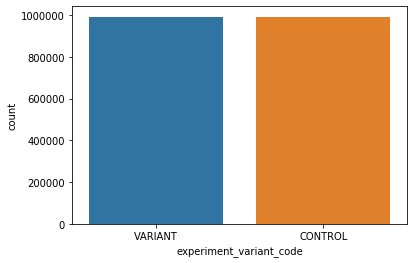

In [11]:
#Visualize how data clean up impacted control and variant populations
ax = sns.countplot(x="experiment_variant_code", data=df)

In [12]:
df["experiment_variant_code"].value_counts()

CONTROL    992219
VARIANT    991693
Name: experiment_variant_code, dtype: int64

We can see that even after data clean-up roughly an equal number of users saw the control and variant design


In [13]:
#Checking if the same user was in both control and variant groups (within vs between-subjects comparison)
groups_per_user = df.groupby('user_id')['experiment_variant_code'].nunique()
groups_per_user.value_counts()

1    1983912
Name: experiment_variant_code, dtype: int64

No users saw both designs

In [14]:
#Calculate proportions and totals
mask = (df["experiment_variant_code"] == "CONTROL")
conversions_control = df["converted"][mask].sum()
total_users_control = df["converted"][mask].count()

mask = (df["experiment_variant_code"] == "VARIANT")
conversions_variant = df["converted"][mask].sum()
total_users_variant = df["converted"][mask].count()

In [15]:
#Check what sample size is required
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)

print("Required sample size: ", round(sample_size), " per group")

Required sample size:  12810  per group


Given sample ( >900K records per group) meets the required sample size

### Comparing conversion likelihood

In [16]:
count = np.array([conversions_control, conversions_variant])
nobs = np.array([total_users_control, total_users_variant])

In [17]:
#Test for proportions based on chi square test
chi2, chi_pval, chi_arr = sms.proportions_chisquare(count, nobs)

if chi_pval < confidence_level:
    print("Reject null hypothesis at p = ",chi_pval)
else: 
    print("Do not reject the null hypothesis at p = ", round(chi_pval,2))

Do not reject the null hypothesis at p =  0.16


In [18]:
#Test for proportions based on normal (z) test
z_stat, z_pval = sms.proportions_ztest(count, nobs, alternative = 'two-sided')

if z_pval < confidence_level:
    print("Reject null hypothesis at p = ",z_pval)
else: 
    print("Do not reject the null hypothesis at p = ", round(z_pval,2))

Do not reject the null hypothesis at p =  0.16


Because p-value is higher than 0.05 we can conclude that the difference is not greater than chance. Put
another way, we can be about 82% sure that control designs and variant designs have the same conversion rates — a level
of certainty that falls within the usual criterion for claiming a significant difference. Control design's conversion rate value of 8.47% is higher only by 0.06, and not statistically distinguishable from Variant design's booking value of 8.53 at this sample size.

### Calculating confidence interval

In [19]:
#Calculate pooled probability
prob_pooled = (conversions_control + conversions_variant) / (total_users_control + total_users_variant)

In [20]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_variant))
margin_of_error = se_pooled * z_stat

In [21]:
#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_variant / total_users_variant) - (conversions_control / total_users_control)

In [22]:
#Test if we can reject the null hypothesis
lower_bound_z = d_hat - margin_of_error
upper_bound_z = d_hat + margin_of_error

print("The lower bound of the confidence interval is ", round(lower_bound_z * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound_z * 100, 2), "%")

The lower bound of the confidence interval is  0.11 %
The upper bound of the confidence interval is  0.0 %


### Comparing mean booking values

In [23]:
#Get the data for test
mask = (df["experiment_variant_code"] == "CONTROL")
data_control = df["booking_gbv"][mask]

mask = (df["experiment_variant_code"] == "VARIANT")
data_variant = df["booking_gbv"][mask]

In [24]:
t_stat, t_pval, t_df = sms.ttest_ind(data_control, data_variant, usevar = "unequal")
if t_pval < confidence_level:
    print("Reject null hypothesis at p = ", round(t_pval,5))
else: 
    print("Do not reject the null hypothesis at p = ", round(t_pval,5))

Reject null hypothesis at p =  0.00233


Because p-value is rather small (well below 0.05) we can conclude that the difference is greater than chance. Put
another way, we can be about 99.8% sure that control designs and variant designs have different booking values — a level
of certainty that falls within the usual criterion for claiming a significant difference. Control design's booking value of 52.66 is higher, and statistically distinguishable from Variant design's booking value of 50.12 at this sample size.

In [25]:
#Calculate nobs 
N1 = data_control.count()
N2 = data_variant.count()

#Calculate variance 
var1 = data_control.var()
var2 = data_variant.var()

#Calculate standard error
stand_error = math.sqrt((var1/N1)+(var2/N2))
diff_mean = data_control.mean() - data_variant.mean()
alpha=0.05
crit_val = st.t.ppf(1.0 - alpha/2, t_df)

#Calculate lower and upper interval
lower_bound_t = round(diff_mean-crit_val*stand_error,2)
upper_bound_t = round(diff_mean+crit_val*stand_error,2)

print("The lower bound of the confidence interval is ", lower_bound_t, "%")
print("The upper bound of the confidence interval is ", upper_bound_t, "%")

The lower bound of the confidence interval is  0.9 %
The upper bound of the confidence interval is  4.17 %
